In [1]:
import os
import pandas as pd 
# import polars as pl # like pandas, but much faster
# import polars.selectors as cs
import numpy as np
import os, shutil, glob
# from random import randint
import re, math
# from pathlib import Path


os.getcwd()


'/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data'

In [2]:
def list_features(df):
    return [c for c in df.columns if not c.startswith("Metadata")]

def list_metadata(df):
    return [c for c in df.columns if c.startswith("Metadata")]

def get_featuredata(df):
    """Return DataFrame of numeric, non-metadata feature columns."""
    feature_cols = list_features(df)
    assert all(np.issubdtype(df[c].dtype, np.number) for c in feature_cols), \
        "Non-numeric columns found in feature data"
    return df[feature_cols]

def get_metadata(df):
    return df[list_metadata(df)]

### Read data

In [4]:
DataSingleCell =  pd.read_parquet("/home/jovyan/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data/FeaturesImages_291025_none/SingleCell/HCT116.parquet") 

In [ ]:
### The plan 

# CONTEXT: Technical artifact from imaging depth (z-plane) creates variation that overshadows
# biological variation from radial distance (spheroid outer→inner layers).
# In center z-planes, we can see radial biology within a single plane.

# PLAN A (full dataset):
# 0) Make sure to keep track of metadata on the X,Y,Z location of each cell in the 3D image stack. 
#    Location_Center_X
#    Location_Center_Y
#    Location_Center_Z
#    - Compute radial distance from spheroid center for each cell
# 1) Squeeze the metadata into the index of the dataframe.
# 2) Harmony integration using z-plane as batch covariate to remove technical depth artifacts
#    - Test on DMSO controls first to verify it reveals radial biology
# 3) Assign each cell to a cluster (Leiden clustering), just do it for a handful of dmso controls first.
# 4) Check if clusters correspond to different layers of the 3D cell culture (radial distance from center)
# 5) aggregate single cell data to spheroid layer level (mean or median feature values per layer)
# 6) continue preprocessing and clustering at the spheroid layer level.

# PLAN B (fallback if Harmony removes too much biology):
# Focus analysis only on central z-planes where technical and biological signals are less confounded.
# This avoids the confounding issue at top/bottom planes where radial distance ≈ z-plane position.


In [ ]:
# ## Useful from elsewhere:
# # Remove unnecessary columns
# pattern = re.compile(r'FileName|PathName|ObjectNumber|ImageNumber|AcqID')

# # But skip working in polars for now, as harmony is in python/pandas
# columns_to_keep = [col for col in df.columns if not pattern.search(col)]
# dfOut = df.select(columns_to_keep)

In [ ]:
# ## Original harmony code snippet: 
# df_toharmonize = for_harmony.copy()


# # Select the data for PCA
# training_data = get_featuredata(df_toharmonize)

# # Perform PCA
# pca = PCA(n_components=20)
# pca.fit(training_data)
# pca_embedding = pca.transform(training_data)

In [5]:
# Extract z-plane from filename and create spheroid ID
DataSingleCell['Metadata_Z'] = DataSingleCell['FileName_CONC_cytoplasm'].str.extract(r'-z(\d+)-')[0].astype(int)
DataSingleCell['Metadata_Spheroid_ID'] = (DataSingleCell['Metadata_Barcode'].astype(str) + '_' + 
                                           DataSingleCell['Metadata_Well'].astype(str)
)

# Calculate 2D radial distance from equatorial plane center
def calc_radial_distance(df):
    """Calculate 2D radial distance from equatorial plane center for each cell."""
    centers = []
    for sph_id, sph_data in df.groupby('Metadata_Spheroid_ID'):
        # Find equatorial plane (largest radial extent)
        max_radius, center_x, center_y = 0, None, None
        for z, z_data in sph_data.groupby('Metadata_Z'):
            cx, cy = z_data['Location_Center_X_cytoplasm'].mean(), z_data['Location_Center_Y_cytoplasm'].mean()
            r_max = np.sqrt((z_data['Location_Center_X_cytoplasm'] - cx)**2 + 
                           (z_data['Location_Center_Y_cytoplasm'] - cy)**2).max()
            if r_max > max_radius:
                max_radius, center_x, center_y = r_max, cx, cy
        centers.append({'Metadata_Spheroid_ID': sph_id, 'Center_X': center_x, 'Center_Y': center_y})
    
    # Merge centers and calculate radial distance
    centers_df = pd.DataFrame(centers)
    df = df.merge(centers_df, on='Metadata_Spheroid_ID', how='left')
    df['Metadata_Radial_Distance'] = np.sqrt((df['Location_Center_X_cytoplasm'] - df['Center_X'])**2 + 
                                              (df['Location_Center_Y_cytoplasm'] - df['Center_Y'])**2)
    return df.drop(columns=['Center_X', 'Center_Y'])

DataSingleCell = calc_radial_distance(DataSingleCell)
print(f"Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance")
print(f"Radial distance range: {DataSingleCell['Metadata_Radial_Distance'].min():.1f} - {DataSingleCell['Metadata_Radial_Distance'].max():.1f} pixels")

Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance
Radial distance range: 0.2 - 902.3 pixels


In [10]:
# Check unique z planes
DataSingleCell['Metadata_Z'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

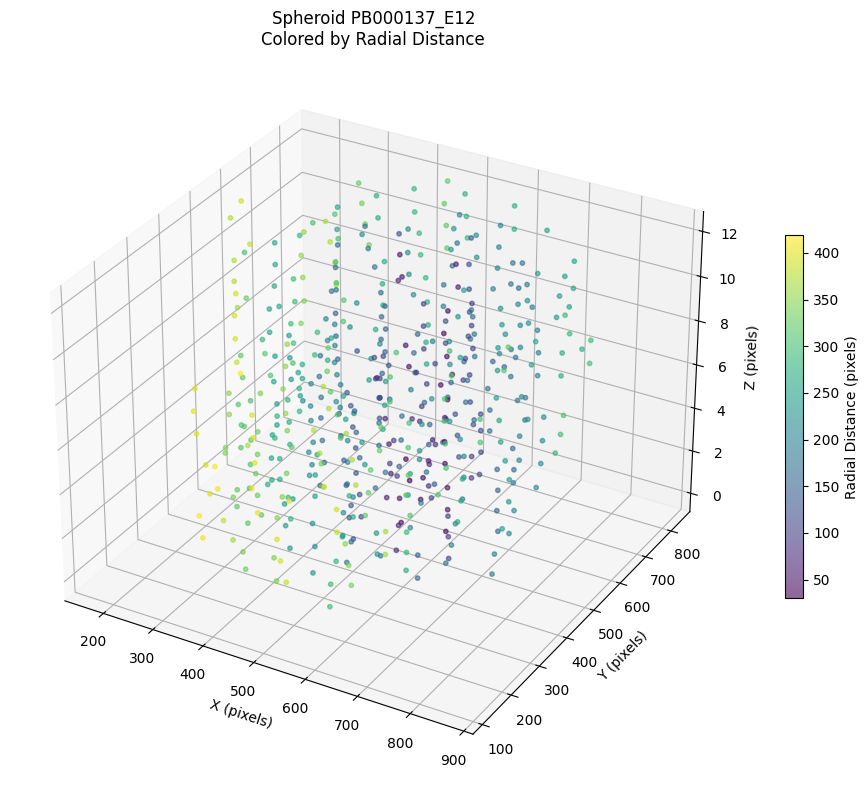

In [7]:
# Visualize a sample spheroid in 3D colored by radial distance
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

sample_sph = DataSingleCell['Metadata_Spheroid_ID'].iloc[1]
sample_data = DataSingleCell[DataSingleCell['Metadata_Spheroid_ID'] == sample_sph]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sample_data['Location_Center_X_cytoplasm'], 
                     sample_data['Location_Center_Y_cytoplasm'],
                     sample_data['Metadata_Z'],
                     c=sample_data['Metadata_Radial_Distance'],
                     cmap='viridis', s=10, alpha=0.6)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Z (pixels)')
ax.set_title(f'Spheroid {sample_sph}\nColored by Radial Distance')
plt.colorbar(scatter, label='Radial Distance (pixels)', shrink=0.5)
plt.tight_layout()
plt.show()